In [337]:
import os
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import signal as sig
from scipy import ndimage as ndi

In [338]:
image1 = cv2.imread('im4.jpg')[:,:,[2,1,0]]
image2 = cv2.imread('im3.jpg')[:,:,[2,1,0]]
image1 = cv2.resize(image1, (int(image1.shape[1]/4),int(image1.shape[0]/4)), interpolation= cv2.INTER_LINEAR)
image2 = cv2.resize(image2, (int(image2.shape[1]/4),int(image2.shape[0]/4)), interpolation= cv2.INTER_LINEAR)
raw_image1 = image1
raw_image2 = image2

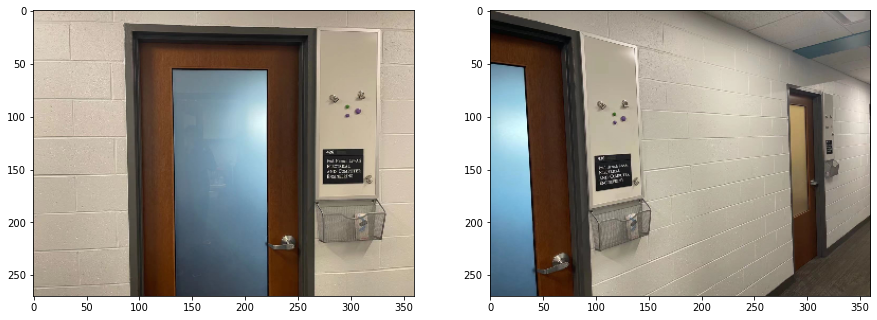

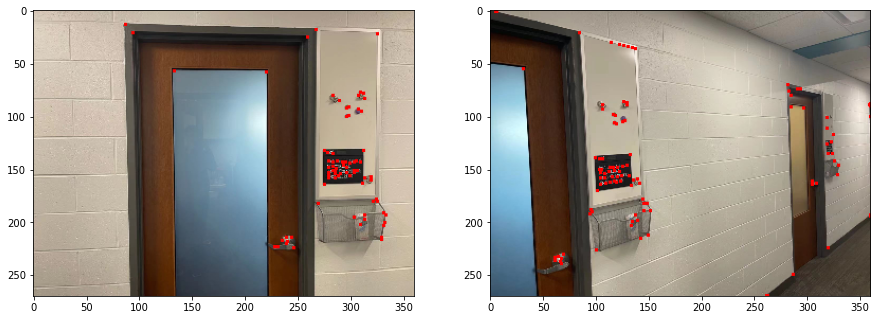

In [339]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
axs[0].imshow(image1)
axs[1].imshow(image2)
plt.show()
gray1 = cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY)
gray1 = np.float32(gray1)
dst1 = cv2.cornerHarris(gray1,2,3,0.05)
dst1[dst1<0.01*dst1.max()] = 0 
dst = np.copy(dst1)
for i in range(2,dst.shape[0]-2):
    for j in range(2,dst.shape[1]-2):
        if(dst1[i,j] != dst1[i-2:i+2,j-2:j+2].max()):
            dst[i,j] = 0
dst1 = dst
dst = cv2.dilate(dst,None)
# Threshold for an optimal value, it may vary depending on the image.
image1[dst != 0]=[255,0,0]

gray2 = cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY)
gray2 = np.float32(gray2)
dst2 = cv2.cornerHarris(gray2,2,3,0.05)
dst2[dst2<0.01*dst2.max()] = 0 
dst = np.copy(dst2)
for i in range(2,dst.shape[0]-2):
    for j in range(2,dst.shape[1]-2):
        if(dst2[i,j] != dst2[i-2:i+2,j-2:j+2].max()):
            dst[i,j] = 0
dst2 = dst
dst = cv2.dilate(dst,None)
# Threshold for an optimal value, it may vary depending on the image.
image2[dst>0.01*dst.max()]=[255,0,0]

fig, axs = plt.subplots(1, 2, figsize=(15, 7))
axs[0].imshow(image1)
axs[1].imshow(image2)
plt.show()
dst1[dst1!=0] = 1
dst2[dst2!=0] = 1

In [340]:
def correlation_coefficient(patch1, patch2):
    product = np.mean((patch1 - patch1.mean()) * (patch2 - patch2.mean()))
    stds = patch1.std() * patch2.std()
    if stds == 0:
        return 0
    else:
        product /= stds
        return product

In [341]:
dist_list1, dist_list2 = [], []
for i in range(dst1.shape[0]):
    for j in range(dst1.shape[1]):
        if(dst1[i,j] != 0):
            dist_list1.append((i,j))
for i in range(dst2.shape[0]):
    for j in range(dst2.shape[1]):
        if(dst2[i,j] != 0):
            dist_list2.append((i,j))


In [342]:
gray1 = cv2.copyMakeBorder(gray1, 5, 5, 5, 5,cv2.BORDER_CONSTANT, None, value = 0 )
gray2 = cv2.copyMakeBorder(gray2, 5, 5, 5, 5,cv2.BORDER_CONSTANT, None, value = 0 )
print(gray1.shape)
NCC = np.zeros((len(dist_list1),len(dist_list2)))
for i in range(len(dist_list1)):
    for j in range(len(dist_list2)):
        NCC[i,j] = correlation_coefficient(gray1[dist_list1[i][0]:dist_list1[i][0]+10,dist_list1[i][1]:dist_list1[i][1]+10], \
                                          gray2[dist_list2[j][0]:dist_list2[j][0]+10,dist_list2[j][1]:dist_list2[j][1]+10])

(280, 370)


In [343]:
def find_corr(NCC,dist_list1,dist_list2):
    temp = NCC.copy()
    corr_points = []
    for i in range(min(len(dist_list1),len(dist_list2))):
        max_val = np.amax(temp.flatten())
        if(max_val <= 0.3):
            break
        x,y = int(np.where(temp == max_val)[0]),int(np.where(temp == max_val)[1])
        temp[x,y] = 0
        corr_points.append([dist_list1[x],dist_list2[y]])
    return corr_points

In [344]:
def draw_inliers_and_outliers(image1,image2,inliears,outliers):
    image = np.concatenate((image1, image2), axis=1)
    h = image1.shape[0]
    w = image2.shape[1]
    plt.figure(figsize = (20,9))
    for points in inliears:
        y = [points[0][0],points[1][0]]
        x = [points[0][1],w+points[1][1]]
        plt.plot(x,y, color="green", linewidth=1)
    for points in outliers:
        y = [points[0][0],points[1][0]]
        x = [points[0][1],w+points[1][1]]
        plt.plot(x,y, color="red", linewidth=1)   
    
    plt.axis('off')
    plt.imshow(image)
    plt.show()
    

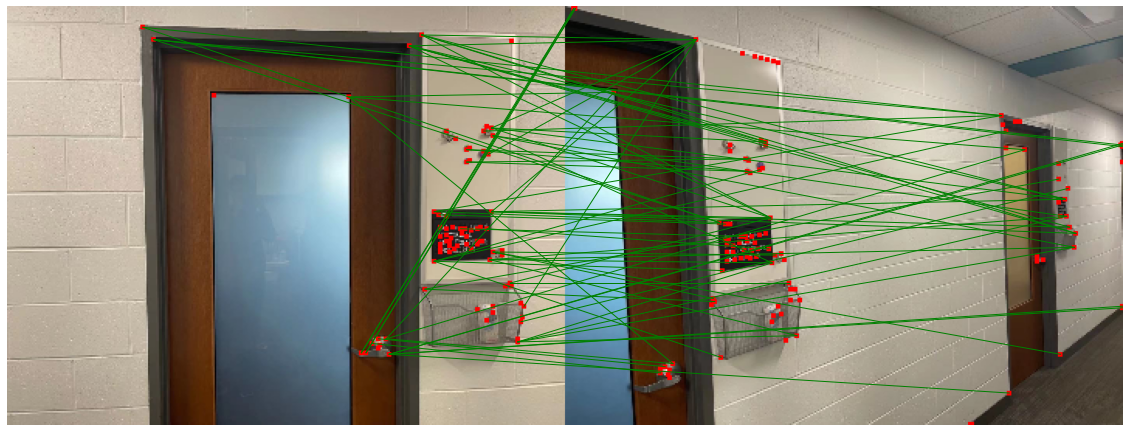

In [345]:
corr = find_corr(NCC,dist_list1,dist_list2)
draw_inliers_and_outliers(raw_image1,raw_image2,corr,[])

In [346]:
im1_pnts = []
im2_pnts = []
for pnts in corr:
    im1_pnts.append(pnts[0])
    im2_pnts.append(pnts[1])
im1_pnts = np.array(im1_pnts)
im2_pnts = np.array(im2_pnts)


In [354]:
def getHomography(p1, p2):
    h,state = cv2.findHomography(p1, p2, cv2.RANSAC,2.0)
    return h
def find_inliers_and_outliers(im2_pnts, im1_pnts,h,t):
    inliers = []
    outliers = []
    for i in range(len(im1_pnts)):
        a = np.dot(np.append(im2_pnts[i],1),np.transpose(h))
        a = a/a[-1]
        if(abs(np.sum(a-np.append(im1_pnts[i],1)))>t):
            outliers.append([im1_pnts[i],im2_pnts[i]])
        else:
            inliers.append([im1_pnts[i],im2_pnts[i]])
    return inliers,outliers

[[ 8.21750144e-01 -2.31539698e-01  1.71148003e+01]
 [-6.42715223e-03  2.62051413e-01  1.99420343e+02]
 [ 1.44894318e-04 -2.06174188e-03  1.00000000e+00]]
[[ 8.21750144e-01 -2.31539698e-01  1.71148003e+01]
 [-6.42715223e-03  2.62051413e-01  1.99420343e+02]
 [ 1.44894318e-04 -2.06174188e-03  1.00000000e+00]]


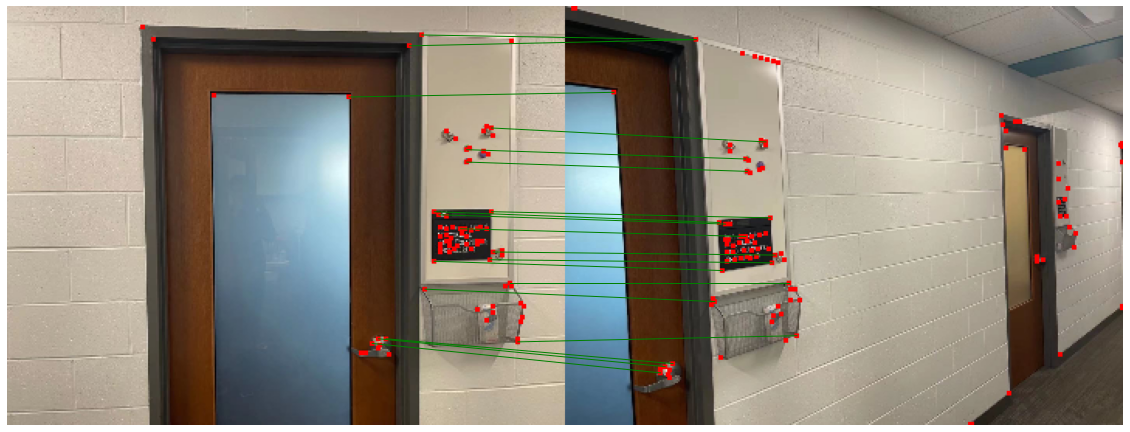

In [365]:
h = getHomography(im2_pnts,im1_pnts)
print(h)
inliers,outliers = find_inliers_and_outliers(im2_pnts,im1_pnts,h,3)
im1_pnts,im2_pnts = [],[]
for pnts in inliers:
    im1_pnts.append(pnts[0])
    im2_pnts.append(pnts[1])
im1_pnts = np.array(im1_pnts)
im2_pnts = np.array(im2_pnts)
print(h)
draw_inliers_and_outliers(raw_image1,raw_image2,inliers,outliers)

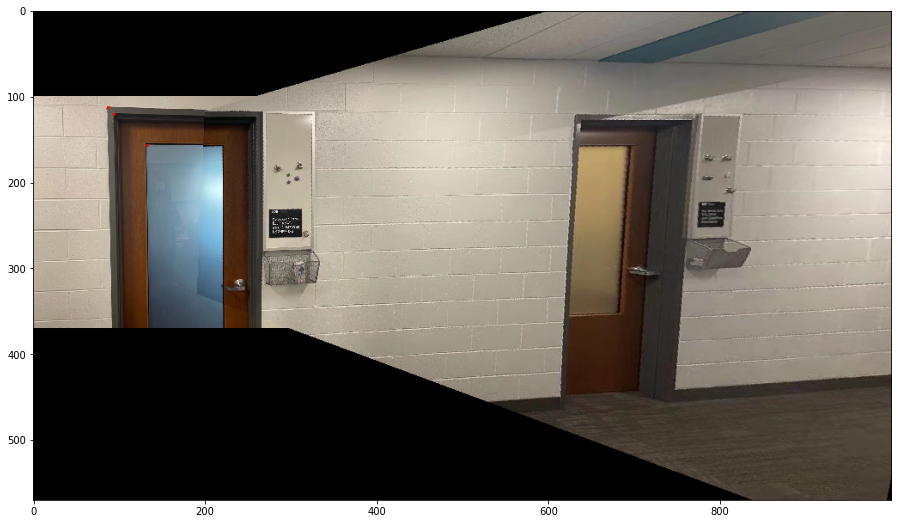

In [369]:
image = np.zeros((570,1000,3), np.uint8)
image[100:370,0:360,] = image1
image2 = cv2.imread('im3.jpg')[:,:,[2,1,0]]
for i in range(0,image.shape[0]):
    for j in range(0,image.shape[1]):
        a = np.dot(np.linalg.inv(h),np.array([[i-100],[j],[1]]))
        a = a/a[-1]
        u,v = round(float(a[0])*4),round(float(a[1])*4)
        if(0<=u<270*4 and 0<=v<360*4):
            image[i,j,] = image2[round(u),round(v)]
            
plt.figure(figsize = (20,9))
plt.imshow(image)

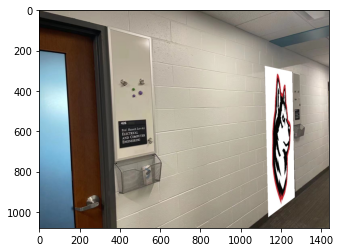

In [382]:
pnts_dst = np.array([[277,1121],[306,1257],[1027,1138],[928,1270]])
image3 = cv2.imread('im6.jpg')[:,:,[2,1,0]]
pnts_src = np.array([[0,0],[0,400],[400,0],[400,400]])
h = getHomography(pnts_src,pnts_dst)
for i in range(0,image2.shape[0]):
    for j in range(0,image2.shape[1]):
        a = np.dot(np.linalg.inv(h),np.array([[i],[j],[1]]))
        a = a/a[-1]
        u,v = round(float(a[0])),round(float(a[1]))
        if(0<=u<400 and 0<=v<400):
            image2[i,j,] = image3[round(u),round(v)]
plt.imshow(image2)

In [ ]:
Ixx = ndi.gaussian_filter(I_x**2, sigma=1)
Ixy = ndi.gaussian_filter(I_y*I_x, sigma=1)
Iyy = ndi.gaussian_filter(I_y**2, sigma=1)

k = 0.02
window_size = 5
offset = int((window_size-1)/2)
r_matrix = np.copy(gray1)
r_matrix.fill(0)
for y in range(offset, Ixx.shape[0]-offset):
    for x in range(offset, Ixx.shape[1]-offset):
        Sxx = np.sum(Ixx[y-offset:y+1+offset, x-offset:x+1+offset])
        Syy = np.sum(Iyy[y-offset:y+1+offset, x-offset:x+1+offset])
        Sxy = np.sum(Ixy[y-offset:y+1+offset, x-offset:x+1+offset])
        det = (Sxx.astype(np.float64) * Syy.astype(np.float64)) - (Sxy.astype(np.float64)**2)
        trace = Sxx + Syy
        r = det - k*(trace**2)
        if(r > 1e9):
            r_matrix[y,x] = r


In [ ]:
nms_r_matrix = r_matrix.copy()
nms_r_matrix.fill(0)
for i in range(5,r_matrix.shape[0]-5):
    for j in range(5,r_matrix.shape[1]-5):
        if(r_matrix[i,j] == r_matrix[i-5:i+5,j-5:j+5].max()):
            nms_r_matrix[i,j] = r_matrix[i,j]

In [ ]:
r_matrix.sum()

In [ ]:
cv2.imshow('dst',image1)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
for i in range(image1.shape[0]):
    for j in range(image1.shape[1]):
        if(nms_r_matrix[i,j]!=0):
            image1[i,j] = [0,0,255]
cv2.imshow('dst',image1)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
image1[dst>0.01*dst.max()]=[0,0,255]

In [ ]:
cv2.imshow('dst',image1)
cv2.waitKey(0)
cv2.destroyAllWindows()